# # English to Hausa Translation Model

# This notebook demonstrates the development of an English to Hausa translation model using Recurrent Neural Networks (RNNs) with an attention mechanism. We'll walk through data preparation, preprocessing, model building, training, and evaluation.

Table of Contents
# Table of Contents

1. [Import Libraries](#import-libraries)
2. [Load and Inspect Dataset](#load-and-inspect-dataset)
3. [Data Cleaning and Preprocessing](#data-cleaning-and-preprocessing)
4. [Tokenization and Sequence Padding](#tokenization-and-sequence-padding)
5. [Train-Test Split](#train-test-split)
6. [Model Building with Attention](#model-building-with-attention)
7. [Model Training](#model-training)
8. [Model Evaluation](#model-evaluation)
9. [Conclusion and Future Work](#conclusion-and-future-work)


1. Import Libraries
We start by [importing the necessary libraries](#import-libraries) for data manipulation, model building, and evaluation.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping


In [6]:
# Load the data
data = pd.read_csv('data/parallel-hausa-tweets.csv')

# Display the first few rows
data.head()


,CleanedMainT,CleanedReplyT,Hausa2EngMainT,Hausa2EngReplyT
0,Jurgen Klopp ya lashe kyautar Fifa ta gwarzon ...,Abunda ya faru tun last week,Jurgen Klopp has won the Fifa World Coach of t...,It's been a while since last week
1,Jurgen Klopp ya lashe kyautar Fifa ta gwarzon ...,Ku sai yanzu ku ke sawa news,Jurgen Klopp has won the Fifa World Coach of t...,You are now wearing news
3,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Allah ya isa tsakaninmu da duk wanda yake da s...,Gunmen kill man and burn sacks of maize in Kaduna,May Allah reach between us and all those who a...
4,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Innalillahi wa innailaihi rajiun. Wannan kasar...,Gunmen kill man and burn sacks of maize in Kaduna,Innalillahi wa innailaihi rajiun. This country...
5,Ƴan bindiga sun kashe mutum da ƙona buhunan ma...,Subhnallah,Gunmen kill man and burn sacks of maize in Kaduna,Subhnallah


In [7]:
def clean_text(text):
    # Convert to string if not already
    text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text


In [8]:
# Assuming the columns are named 'CleanedMainT' for Hausa and 'Hausa2EngMainT' for English
data = data[['CleanedMainT', 'Hausa2EngMainT']].dropna()

# Clean the texts
data['hausa_clean'] = data['CleanedMainT'].apply(clean_text)
data['english_clean'] = data['Hausa2EngMainT'].apply(clean_text)

# Display cleaned data
data[['hausa_clean', 'english_clean']].head()


,hausa_clean,english_clean
0,jurgen klopp ya lashe kyautar fifa ta gwarzon ...,jurgen klopp has won the fifa world coach of t...
1,jurgen klopp ya lashe kyautar fifa ta gwarzon ...,jurgen klopp has won the fifa world coach of t...
3,ƴan bindiga sun kashe mutum da ƙona buhunan ma...,gunmen kill man and burn sacks of maize in kaduna
4,ƴan bindiga sun kashe mutum da ƙona buhunan ma...,gunmen kill man and burn sacks of maize in kaduna
5,ƴan bindiga sun kashe mutum da ƙona buhunan ma...,gunmen kill man and burn sacks of maize in kaduna


In [9]:
# Remove rows with empty translations
data = data[(data['hausa_clean'].str.len() > 0) & (data['english_clean'].str.len() > 0)]

print(f"Total samples after cleaning: {len(data)}")


Total samples after cleaning: 292


In [10]:
# Prepare input and target texts
input_texts = data['hausa_clean'].tolist()
target_texts = data['english_clean'].tolist()

# Add start and end tokens to target texts
target_texts = ['<start> ' + text + ' <end>' for text in target_texts]


In [11]:
# Tokenizer for input language (Hausa)
input_tokenizer = Tokenizer(filters='')
input_tokenizer.fit_on_texts(input_texts)
input_sequences = input_tokenizer.texts_to_sequences(input_texts)
input_word_index = input_tokenizer.word_index
num_encoder_tokens = len(input_word_index) + 1  # +1 for padding token

# Tokenizer for target language (English)
target_tokenizer = Tokenizer(filters='')
target_tokenizer.fit_on_texts(target_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)
target_word_index = target_tokenizer.word_index
num_decoder_tokens = len(target_word_index) + 1  # +1 for padding token


In [12]:
max_encoder_seq_length = max([len(seq) for seq in input_sequences])
max_decoder_seq_length = max([len(seq) for seq in target_sequences])

print(f"Max sequence length for inputs: {max_encoder_seq_length}")
print(f"Max sequence length for outputs: {max_decoder_seq_length}")


Max sequence length for inputs: 22
Max sequence length for outputs: 28


In [13]:
encoder_input_data = pad_sequences(input_sequences, maxlen=max_encoder_seq_length, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_decoder_seq_length, padding='post')


In [14]:
# Prepare decoder target data
decoder_target_sequences = []
for seq in target_sequences:
    decoder_target_sequences.append(seq[1:])  # Remove the first token (start token)

decoder_target_data = pad_sequences(decoder_target_sequences, maxlen=max_decoder_seq_length, padding='post')


In [15]:
# Split data into training and validation sets
encoder_input_train, encoder_input_val, decoder_input_train, decoder_input_val, decoder_target_train, decoder_target_val = train_test_split(
    encoder_input_data, decoder_input_data, decoder_target_data, test_size=0.2, random_state=42)

print(f"Training samples: {len(encoder_input_train)}")
print(f"Validation samples: {len(encoder_input_val)}")


Training samples: 233
Validation samples: 59


In [16]:
# Encoder input layer
encoder_inputs = Input(shape=(None,), name='encoder_inputs')
# Embedding layer for encoder
encoder_embedding = Embedding(input_dim=num_encoder_tokens, output_dim=256, name='encoder_embedding')(encoder_inputs)
# Encoder LSTM
encoder_lstm = LSTM(256, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder input layer
decoder_inputs = Input(shape=(None,), name='decoder_inputs')
# Embedding layer for decoder
decoder_embedding = Embedding(input_dim=num_decoder_tokens, output_dim=256, name='decoder_embedding')(decoder_inputs)
# Decoder LSTM
decoder_lstm = LSTM(256, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)


In [17]:
# Dense layer for output
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)


In [18]:
# Define the model that takes encoder and decoder inputs and outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [19]:
# Reshape decoder target data to be compatible with sparse_categorical_crossentropy
decoder_target_train = decoder_target_train.reshape(*decoder_target_train.shape, 1)
decoder_target_val = decoder_target_val.reshape(*decoder_target_val.shape, 1)


In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


In [21]:
history = model.fit(
    [encoder_input_train, decoder_input_train],
    decoder_target_train,
    batch_size=64,
    epochs=50,
    validation_data=([encoder_input_val, decoder_input_val], decoder_target_val),
    callbacks=[early_stopping]
)


Epoch 1/50

4/4 [==============================] - 4s 353ms/step - loss: 5.5937 - val_loss: 3.1636
Epoch 2/50
4/4 [==============================] - 1s 137ms/step - loss: 2.6731 - val_loss: 2.9109
Epoch 3/50
4/4 [==============================] - 1s 137ms/step - loss: 2.4433 - val_loss: 2.8954
Epoch 4/50
4/4 [==============================] - 1s 137ms/step - loss: 2.4661 - val_loss: 2.7838
Epoch 5/50
4/4 [==============================] - 1s 144ms/step - loss: 2.3098 - val_loss: 2.8481
Epoch 6/50
4/4 [==============================] - 1s 205ms/step - loss: 2.3542 - val_loss: 2.6947
Epoch 7/50
4/4 [==============================] - 1s 210ms/step - loss: 2.2005 - val_loss: 2.6569
Epoch 8/50
4/4 [==============================] - 1s 181ms/step - loss: 2.3055 - val_loss: 2.6927
Epoch 9/50
4/4 [==============================] - 1s 196ms/step - loss: 2.2222 - val_loss: 2.5887
Epoch 10/50
4/4 [==============================] - 1s 212ms/step - loss: 2.1221 - val_loss: 2.8068
Epoch 11/50
4/4 [=

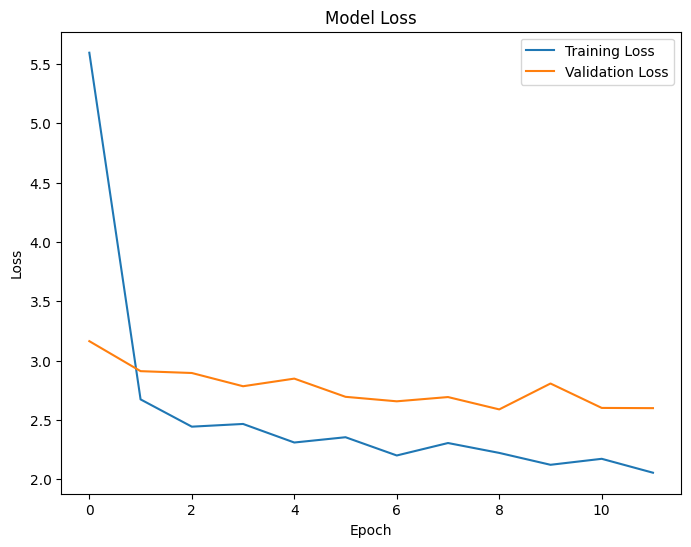

In [22]:
# Plot training & validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [23]:
encoder_model = Model(encoder_inputs, encoder_states)


In [24]:
# Decoder states inputs
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Embedding layer
dec_emb2 = decoder_embedding(decoder_inputs)

# LSTM with states
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# Dense layer
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


TypeError: 'KerasTensor' object is not callable